<a href="https://colab.research.google.com/github/jwtan0421/ai_llm/blob/main/lhy/ml_2025_hw4_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Transformer

### TA's Slide
[Slide](https://docs.google.com/presentation/d/1ga0d43mWyrfHjdkp7FG3iWcEKTGr8CdkifYhhi4LBY8/edit?usp=sharing)

### Description
In this assignment, we are tasked with utilizing a transformer decoder-only architecture for pretraining, with a focus on next-token prediction, applied to Pokémon images.

Please feel free to mail us if you have any questions.

ntu-ml-2025-spring-ta@googlegroups.com

# Utilities

### Download packages

In [ ]:
!pip install datasets==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.5 MB/s eta 0:00:00


### Import Packages

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional

### Check Devices

In [ ]:
!nvidia-smi

Tue Feb 25 02:45:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Set Random Seed

In [ ]:
set_seed(0)

# Prepare Data

### Define Dataset

In [ ]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

### Download Dataset & Prepare Dataloader

In [ ]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/175k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/632 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/80 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/80 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/297 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/167 [00:00<?, ? examples/s]

### Visualization

In [ ]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

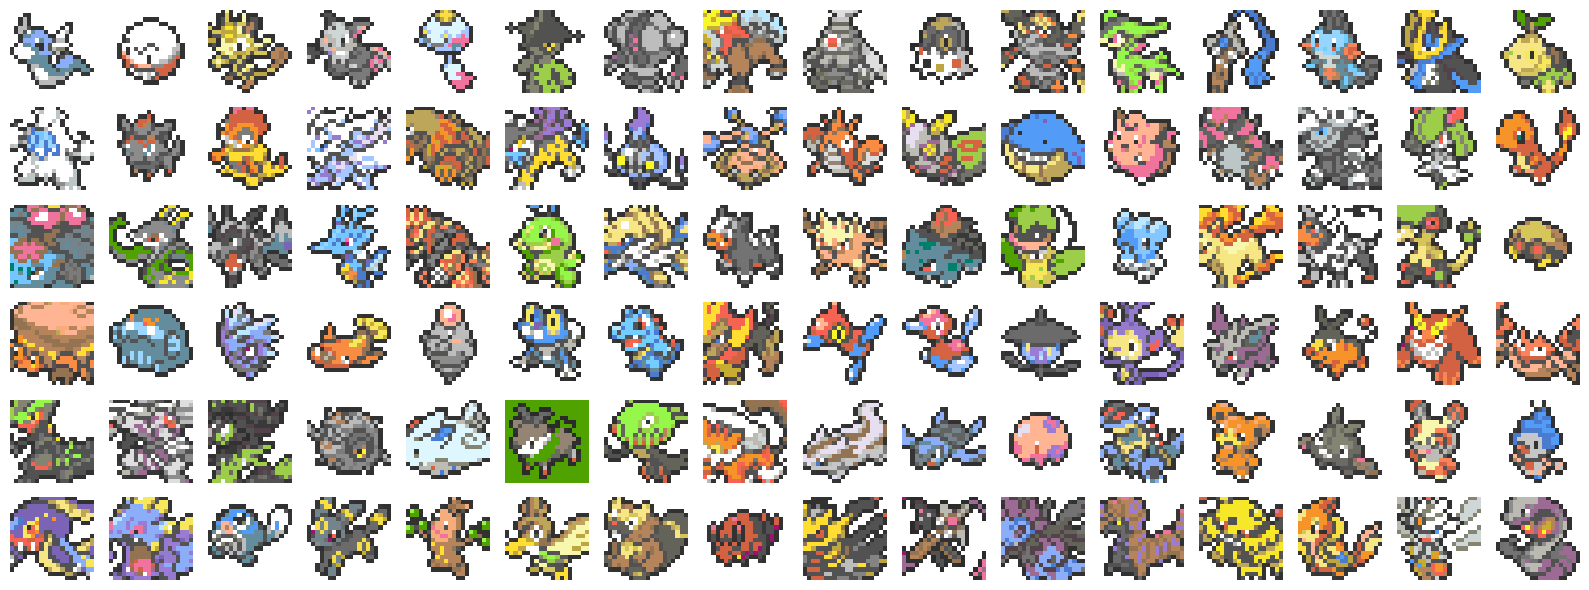

In [ ]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

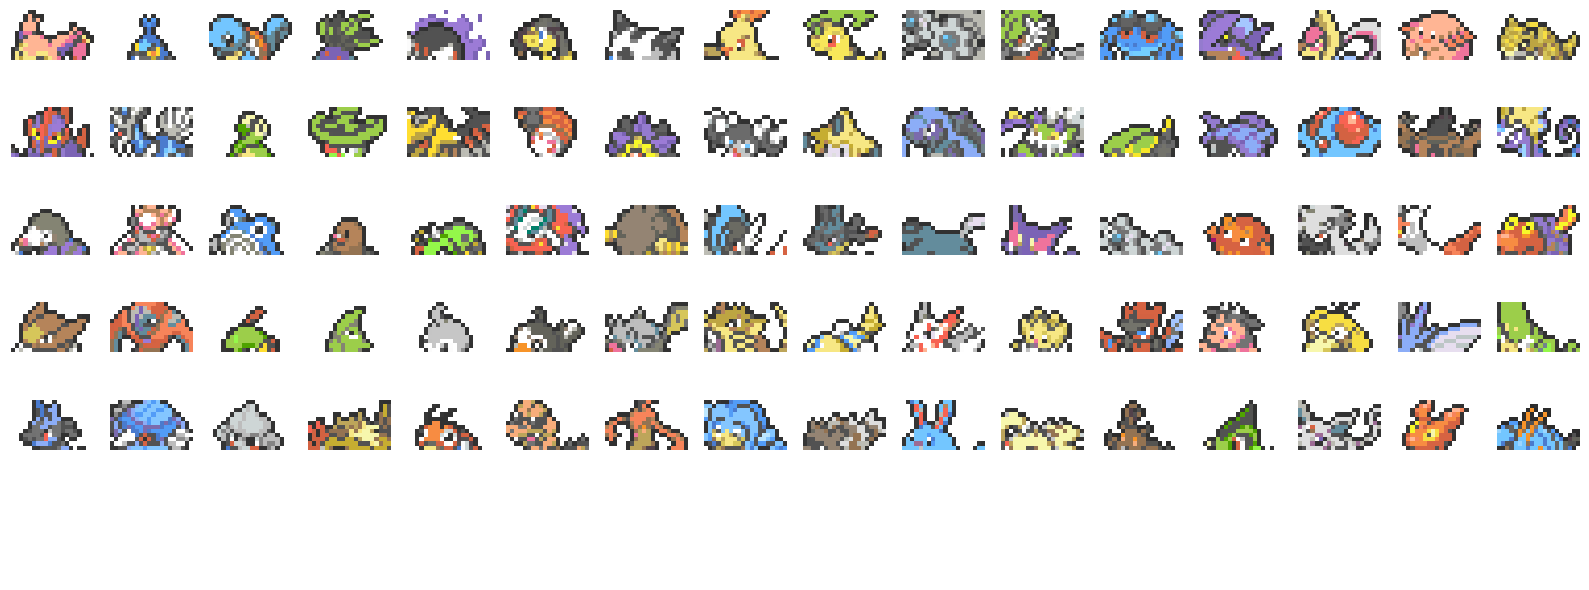

In [ ]:
# Visualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

# Prepare Model

### Model Configuration
Here, we define the model configuration, including the architecture and key hyperparameters such as the number of attention heads, layers, embedding size, and more.
*   Hint 1: Adjust hyperparameters here for improved performance.
*   Hint 2: Experiment with different model architectures, such as Llama, Mistral, or Qwen, to enhance performance.
  * [LlamaConfig](https://huggingface.co/docs/transformers/model_doc/llama#transformers.LlamaConfig)
  * [MistralConfig](https://huggingface.co/docs/transformers/model_doc/mistral#transformers.MistralConfig)
  * [Qwen2Config](https://huggingface.co/docs/transformers/model_doc/qwen2#transformers.Qwen2Config)


In [ ]:
# Define GPT-2 model configuration as a dictionary
gpt2_config = {
    "activation_function": "gelu_new",    # Activation function used in the model
    "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
    "attn_pdrop": 0.1,            # Dropout rate for attention layers
    "embd_pdrop": 0.1,            # Dropout rate for embeddings
    "initializer_range": 0.02,        # Standard deviation for weight initialization
    "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
    "model_type": "gpt2",           # Type of model
    "n_ctx": 128,               # Context size (maximum sequence length)
    "n_embd": 64,              # Embedding size
    "n_head": 2,               # Number of attention heads
    "n_layer": 2,              # Number of transformer layers
    "n_positions": 400,           # Maximum number of token positions
    "resid_pdrop": 0.1,           # Dropout rate for residual connections
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

# Load GPT-2 model configuration from dictionary
config = GPT2Config.from_dict(gpt2_config)

### Load Model

In [ ]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(167, 64)
    (wpe): Embedding(400, 64)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=192, nx=64)
          (c_proj): Conv1D(nf=64, nx=64)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=256, nx=64)
          (c_proj): Conv1D(nf=64, nx=256)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=64, out_features=167, bias=False)
)
Trainable Parameters: 136,384


# Train and Inference

### Training Arguments
Here, we define the number of epochs for training, the learning rate, the optimizer, and the loss function.
*   Hint 3: Adjust the number of epochs and learning rate here to improve performance.

In [ ]:
# Training Parameters
epochs = 50                                      # Number of training epochs
learning_rate = 1e-3                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

### Save Model Function

In [ ]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

### Train

We save the checkpoint with the lowest training loss since validation set reconstruction accuracy doesn't directly reflect the model's image generation quality.
*   Hint 4: Train a classifier to check if an image looks like a Pokémon or not. (Optional)

In [ ]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/50: 100%|██████████| 40/40 [00:01<00:00, 25.60it/s]


Epoch 1/50, Loss: 3.7601


Evaluating: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch 1/50, Reconstruction Accuracy: 0.4106
Model saved at checkpoints/best_model.pth (Loss: 3.7601, Epoch: 1)


Training Epoch 2/50: 100%|██████████| 40/40 [00:00<00:00, 67.70it/s]


Epoch 2/50, Loss: 2.7297


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch 2/50, Reconstruction Accuracy: 0.4063
Model saved at checkpoints/best_model.pth (Loss: 2.7297, Epoch: 2)


Training Epoch 3/50: 100%|██████████| 40/40 [00:00<00:00, 56.91it/s]


Epoch 3/50, Loss: 2.4347


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 3/50, Reconstruction Accuracy: 0.4067
Model saved at checkpoints/best_model.pth (Loss: 2.4347, Epoch: 3)


Training Epoch 4/50: 100%|██████████| 40/40 [00:00<00:00, 85.19it/s]


Epoch 4/50, Loss: 2.2727


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 4/50, Reconstruction Accuracy: 0.4124
Model saved at checkpoints/best_model.pth (Loss: 2.2727, Epoch: 4)


Training Epoch 5/50: 100%|██████████| 40/40 [00:00<00:00, 83.33it/s]


Epoch 5/50, Loss: 2.1685


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Epoch 5/50, Reconstruction Accuracy: 0.4040
Model saved at checkpoints/best_model.pth (Loss: 2.1685, Epoch: 5)


Training Epoch 6/50: 100%|██████████| 40/40 [00:00<00:00, 89.19it/s]


Epoch 6/50, Loss: 2.0952


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Epoch 6/50, Reconstruction Accuracy: 0.4061
Model saved at checkpoints/best_model.pth (Loss: 2.0952, Epoch: 6)


Training Epoch 7/50: 100%|██████████| 40/40 [00:00<00:00, 89.65it/s]


Epoch 7/50, Loss: 2.0363


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Epoch 7/50, Reconstruction Accuracy: 0.3893
Model saved at checkpoints/best_model.pth (Loss: 2.0363, Epoch: 7)


Training Epoch 8/50: 100%|██████████| 40/40 [00:00<00:00, 88.08it/s]


Epoch 8/50, Loss: 1.9878


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Epoch 8/50, Reconstruction Accuracy: 0.4061
Model saved at checkpoints/best_model.pth (Loss: 1.9878, Epoch: 8)


Training Epoch 9/50: 100%|██████████| 40/40 [00:00<00:00, 81.49it/s]


Epoch 9/50, Loss: 1.9453


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 9/50, Reconstruction Accuracy: 0.4095
Model saved at checkpoints/best_model.pth (Loss: 1.9453, Epoch: 9)


Training Epoch 10/50: 100%|██████████| 40/40 [00:00<00:00, 84.43it/s]


Epoch 10/50, Loss: 1.9180


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Epoch 10/50, Reconstruction Accuracy: 0.4026
Model saved at checkpoints/best_model.pth (Loss: 1.9180, Epoch: 10)


Training Epoch 11/50: 100%|██████████| 40/40 [00:00<00:00, 89.07it/s]


Epoch 11/50, Loss: 1.8896


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Epoch 11/50, Reconstruction Accuracy: 0.4009
Model saved at checkpoints/best_model.pth (Loss: 1.8896, Epoch: 11)


Training Epoch 12/50: 100%|██████████| 40/40 [00:00<00:00, 88.30it/s]


Epoch 12/50, Loss: 1.8640


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Epoch 12/50, Reconstruction Accuracy: 0.3891
Model saved at checkpoints/best_model.pth (Loss: 1.8640, Epoch: 12)


Training Epoch 13/50: 100%|██████████| 40/40 [00:00<00:00, 85.64it/s]


Epoch 13/50, Loss: 1.8417


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Epoch 13/50, Reconstruction Accuracy: 0.3945
Model saved at checkpoints/best_model.pth (Loss: 1.8417, Epoch: 13)


Training Epoch 14/50: 100%|██████████| 40/40 [00:00<00:00, 79.37it/s]


Epoch 14/50, Loss: 1.8230


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 14/50, Reconstruction Accuracy: 0.3866
Model saved at checkpoints/best_model.pth (Loss: 1.8230, Epoch: 14)


Training Epoch 15/50: 100%|██████████| 40/40 [00:00<00:00, 86.22it/s]


Epoch 15/50, Loss: 1.7998


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Epoch 15/50, Reconstruction Accuracy: 0.3658
Model saved at checkpoints/best_model.pth (Loss: 1.7998, Epoch: 15)


Training Epoch 16/50: 100%|██████████| 40/40 [00:00<00:00, 86.09it/s]


Epoch 16/50, Loss: 1.7820


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Epoch 16/50, Reconstruction Accuracy: 0.3678
Model saved at checkpoints/best_model.pth (Loss: 1.7820, Epoch: 16)


Training Epoch 17/50: 100%|██████████| 40/40 [00:00<00:00, 88.53it/s]


Epoch 17/50, Loss: 1.7647


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Epoch 17/50, Reconstruction Accuracy: 0.3765
Model saved at checkpoints/best_model.pth (Loss: 1.7647, Epoch: 17)


Training Epoch 18/50: 100%|██████████| 40/40 [00:00<00:00, 89.12it/s]


Epoch 18/50, Loss: 1.7513


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 18/50, Reconstruction Accuracy: 0.3451
Model saved at checkpoints/best_model.pth (Loss: 1.7513, Epoch: 18)


Training Epoch 19/50: 100%|██████████| 40/40 [00:00<00:00, 77.70it/s]


Epoch 19/50, Loss: 1.7366


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Epoch 19/50, Reconstruction Accuracy: 0.3923
Model saved at checkpoints/best_model.pth (Loss: 1.7366, Epoch: 19)


Training Epoch 20/50: 100%|██████████| 40/40 [00:00<00:00, 87.44it/s]


Epoch 20/50, Loss: 1.7261


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Epoch 20/50, Reconstruction Accuracy: 0.3628
Model saved at checkpoints/best_model.pth (Loss: 1.7261, Epoch: 20)


Training Epoch 21/50: 100%|██████████| 40/40 [00:00<00:00, 89.33it/s]


Epoch 21/50, Loss: 1.7103


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Epoch 21/50, Reconstruction Accuracy: 0.3873
Model saved at checkpoints/best_model.pth (Loss: 1.7103, Epoch: 21)


Training Epoch 22/50: 100%|██████████| 40/40 [00:00<00:00, 91.04it/s]


Epoch 22/50, Loss: 1.7022


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Epoch 22/50, Reconstruction Accuracy: 0.4008
Model saved at checkpoints/best_model.pth (Loss: 1.7022, Epoch: 22)


Training Epoch 23/50: 100%|██████████| 40/40 [00:00<00:00, 85.82it/s]


Epoch 23/50, Loss: 1.6846


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 23/50, Reconstruction Accuracy: 0.3746
Model saved at checkpoints/best_model.pth (Loss: 1.6846, Epoch: 23)


Training Epoch 24/50: 100%|██████████| 40/40 [00:00<00:00, 74.34it/s]


Epoch 24/50, Loss: 1.6794


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Epoch 24/50, Reconstruction Accuracy: 0.3427
Model saved at checkpoints/best_model.pth (Loss: 1.6794, Epoch: 24)


Training Epoch 25/50: 100%|██████████| 40/40 [00:00<00:00, 84.24it/s]


Epoch 25/50, Loss: 1.6673


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Epoch 25/50, Reconstruction Accuracy: 0.3976
Model saved at checkpoints/best_model.pth (Loss: 1.6673, Epoch: 25)


Training Epoch 26/50: 100%|██████████| 40/40 [00:00<00:00, 86.60it/s]


Epoch 26/50, Loss: 1.6519


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Epoch 26/50, Reconstruction Accuracy: 0.3502
Model saved at checkpoints/best_model.pth (Loss: 1.6519, Epoch: 26)


Training Epoch 27/50: 100%|██████████| 40/40 [00:00<00:00, 87.30it/s]


Epoch 27/50, Loss: 1.6426


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Epoch 27/50, Reconstruction Accuracy: 0.3483
Model saved at checkpoints/best_model.pth (Loss: 1.6426, Epoch: 27)


Training Epoch 28/50: 100%|██████████| 40/40 [00:00<00:00, 88.58it/s]


Epoch 28/50, Loss: 1.6281


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 28/50, Reconstruction Accuracy: 0.3597
Model saved at checkpoints/best_model.pth (Loss: 1.6281, Epoch: 28)


Training Epoch 29/50: 100%|██████████| 40/40 [00:00<00:00, 82.64it/s]


Epoch 29/50, Loss: 1.6170


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 29/50, Reconstruction Accuracy: 0.3216
Model saved at checkpoints/best_model.pth (Loss: 1.6170, Epoch: 29)


Training Epoch 30/50: 100%|██████████| 40/40 [00:00<00:00, 84.17it/s]


Epoch 30/50, Loss: 1.6068


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


Epoch 30/50, Reconstruction Accuracy: 0.3434
Model saved at checkpoints/best_model.pth (Loss: 1.6068, Epoch: 30)


Training Epoch 31/50: 100%|██████████| 40/40 [00:00<00:00, 87.99it/s]


Epoch 31/50, Loss: 1.5925


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Epoch 31/50, Reconstruction Accuracy: 0.3502
Model saved at checkpoints/best_model.pth (Loss: 1.5925, Epoch: 31)


Training Epoch 32/50: 100%|██████████| 40/40 [00:00<00:00, 86.10it/s]


Epoch 32/50, Loss: 1.5865


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 32/50, Reconstruction Accuracy: 0.3811
Model saved at checkpoints/best_model.pth (Loss: 1.5865, Epoch: 32)


Training Epoch 33/50: 100%|██████████| 40/40 [00:00<00:00, 78.43it/s]


Epoch 33/50, Loss: 1.5770


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 33/50, Reconstruction Accuracy: 0.3137
Model saved at checkpoints/best_model.pth (Loss: 1.5770, Epoch: 33)


Training Epoch 34/50: 100%|██████████| 40/40 [00:00<00:00, 87.51it/s]


Epoch 34/50, Loss: 1.5674


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Epoch 34/50, Reconstruction Accuracy: 0.3635
Model saved at checkpoints/best_model.pth (Loss: 1.5674, Epoch: 34)


Training Epoch 35/50: 100%|██████████| 40/40 [00:00<00:00, 87.90it/s]


Epoch 35/50, Loss: 1.5577


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 35/50, Reconstruction Accuracy: 0.3545
Model saved at checkpoints/best_model.pth (Loss: 1.5577, Epoch: 35)


Training Epoch 36/50: 100%|██████████| 40/40 [00:00<00:00, 72.44it/s]


Epoch 36/50, Loss: 1.5511


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 36/50, Reconstruction Accuracy: 0.3164
Model saved at checkpoints/best_model.pth (Loss: 1.5511, Epoch: 36)


Training Epoch 37/50: 100%|██████████| 40/40 [00:00<00:00, 86.22it/s]


Epoch 37/50, Loss: 1.5452


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 37/50, Reconstruction Accuracy: 0.3148
Model saved at checkpoints/best_model.pth (Loss: 1.5452, Epoch: 37)


Training Epoch 38/50: 100%|██████████| 40/40 [00:00<00:00, 82.86it/s]


Epoch 38/50, Loss: 1.5394


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Epoch 38/50, Reconstruction Accuracy: 0.3056
Model saved at checkpoints/best_model.pth (Loss: 1.5394, Epoch: 38)


Training Epoch 39/50: 100%|██████████| 40/40 [00:00<00:00, 88.41it/s]


Epoch 39/50, Loss: 1.5336


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


Epoch 39/50, Reconstruction Accuracy: 0.3224
Model saved at checkpoints/best_model.pth (Loss: 1.5336, Epoch: 39)


Training Epoch 40/50: 100%|██████████| 40/40 [00:00<00:00, 87.32it/s]


Epoch 40/50, Loss: 1.5289


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 40/50, Reconstruction Accuracy: 0.3442
Model saved at checkpoints/best_model.pth (Loss: 1.5289, Epoch: 40)


Training Epoch 41/50: 100%|██████████| 40/40 [00:00<00:00, 80.86it/s]


Epoch 41/50, Loss: 1.5199


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Epoch 41/50, Reconstruction Accuracy: 0.2962
Model saved at checkpoints/best_model.pth (Loss: 1.5199, Epoch: 41)


Training Epoch 42/50: 100%|██████████| 40/40 [00:00<00:00, 79.10it/s]


Epoch 42/50, Loss: 1.5131


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


Epoch 42/50, Reconstruction Accuracy: 0.3106
Model saved at checkpoints/best_model.pth (Loss: 1.5131, Epoch: 42)


Training Epoch 43/50: 100%|██████████| 40/40 [00:00<00:00, 87.73it/s]


Epoch 43/50, Loss: 1.5104


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Epoch 43/50, Reconstruction Accuracy: 0.3289
Model saved at checkpoints/best_model.pth (Loss: 1.5104, Epoch: 43)


Training Epoch 44/50: 100%|██████████| 40/40 [00:00<00:00, 89.66it/s]


Epoch 44/50, Loss: 1.5014


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Epoch 44/50, Reconstruction Accuracy: 0.3183
Model saved at checkpoints/best_model.pth (Loss: 1.5014, Epoch: 44)


Training Epoch 45/50: 100%|██████████| 40/40 [00:00<00:00, 84.70it/s]


Epoch 45/50, Loss: 1.4970


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Epoch 45/50, Reconstruction Accuracy: 0.3188
Model saved at checkpoints/best_model.pth (Loss: 1.4970, Epoch: 45)


Training Epoch 46/50: 100%|██████████| 40/40 [00:00<00:00, 84.04it/s]


Epoch 46/50, Loss: 1.4903


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 46/50, Reconstruction Accuracy: 0.3185
Model saved at checkpoints/best_model.pth (Loss: 1.4903, Epoch: 46)


Training Epoch 47/50: 100%|██████████| 40/40 [00:00<00:00, 77.55it/s]


Epoch 47/50, Loss: 1.4920


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Epoch 47/50, Reconstruction Accuracy: 0.3042


Training Epoch 48/50: 100%|██████████| 40/40 [00:00<00:00, 88.16it/s]


Epoch 48/50, Loss: 1.4855


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Epoch 48/50, Reconstruction Accuracy: 0.3119
Model saved at checkpoints/best_model.pth (Loss: 1.4855, Epoch: 48)


Training Epoch 49/50: 100%|██████████| 40/40 [00:00<00:00, 87.09it/s]


Epoch 49/50, Loss: 1.4820


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Epoch 49/50, Reconstruction Accuracy: 0.3250
Model saved at checkpoints/best_model.pth (Loss: 1.4820, Epoch: 49)


Training Epoch 50/50: 100%|██████████| 40/40 [00:00<00:00, 87.41it/s]


Epoch 50/50, Loss: 1.4746


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

Epoch 50/50, Reconstruction Accuracy: 0.3145
Model saved at checkpoints/best_model.pth (Loss: 1.4746, Epoch: 50)


### Inference

In [ ]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

Reconstructed results saved to reconstructed_results.txt


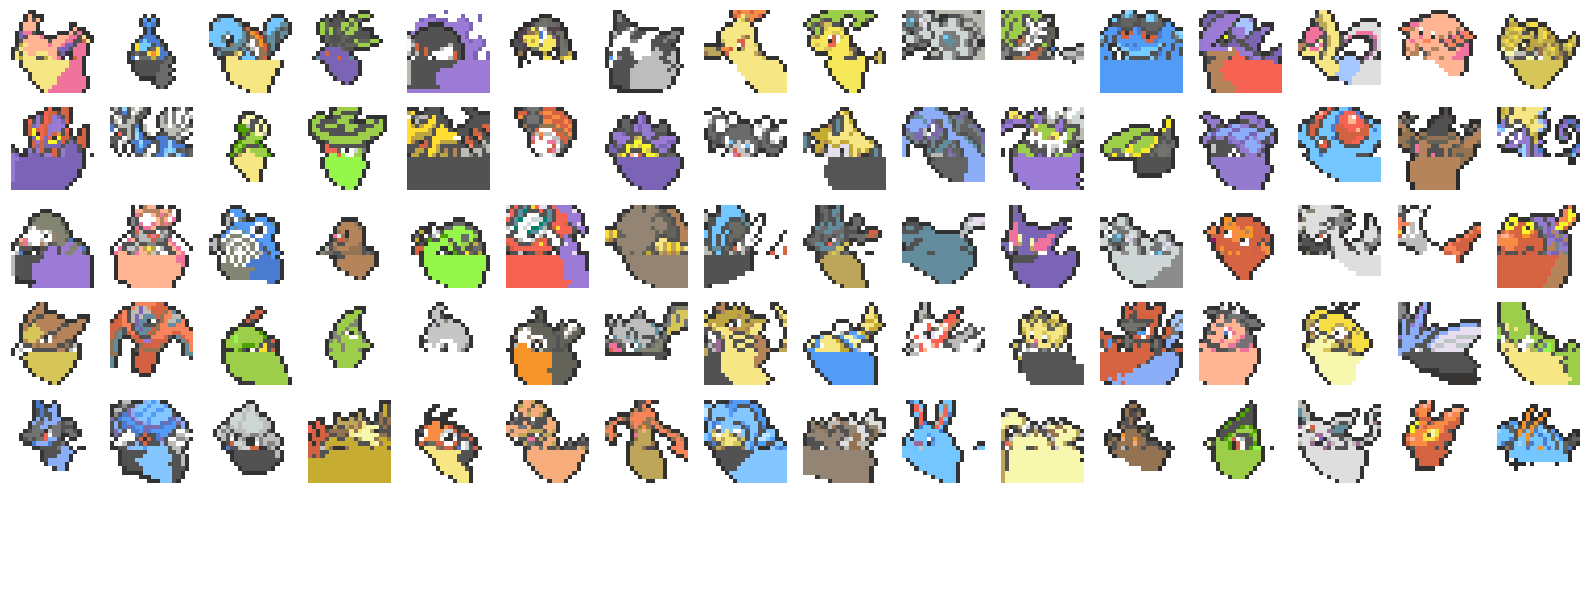

In [ ]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)